In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# multiply population
# output [0,1]
def sigmoidFunction(z, sigmoid_b, slow_scale):
    fz = []
    for num in z:
        fz.append(1/(1 + math.exp(-(num * slow_scale) + sigmoid_b)))
    return fz

def reach_climax_time (df, col_name):
    return (df[col_name].idxmax(axis=0))

def climax_value(df, col_name):
    climax_id = df[col_name].idxmax(axis=0)
    return (df[col_name].loc[climax_id])

In [3]:
# get the total number of serving population of each clinic

df_com = pd.read_excel("community.xlsx")[["社区名称","常住人口","发热诊室", "x", "y"]]#["地址"]
df_com.fillna(10000, inplace = True)

clinic_name_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]
clinic_serve_pop_list = [0,0,0,0]
clinic_name_servepop_dic = dict(zip(clinic_name_list, clinic_serve_pop_list))
for i in range(0, len(df_com)):
    clinic_name_servepop_dic[(df_com.iloc[i]["发热诊室"])] += df_com.iloc[i]["常住人口"]


## Simulation

In [4]:
def simulationFunc (com_population_list = [43750, 70081, 56015, 68615], clinic_name_list = \
    ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"], \
    clinic_scale_list = [15, 16, 17, 18], recover_time = 7, severe_percent = 0.1, sigmoid_b = 4.6, \
    slow_scale = 0.25, max_sim = 100):

    date_list = list(range(0,max_sim,1))

    total_severe_day_list = [[],[],[],[]]
    clinic_avai_day_list = [[],[],[],[]]
    total_severe_pop = [0,0,0,0]
    total_severe_day_arr = np.zeros((4, len(date_list)))

    #current_clinic_avai = clinic_scale_list #updated everyday

    for day in date_list:
        for i in range(4):
            infected_day_arr = np.asarray(
                sigmoidFunction(date_list, sigmoid_b,
                            slow_scale)) * np.array(com_population_list[i])
            new_infected_list = np.diff(np.insert(infected_day_arr, 0, 0))

            # severe cases
            new_infected_arr = np.asarray(new_infected_list)
            new_severe_arr = new_infected_arr * severe_percent

            total_severe_pop[i] = total_severe_pop[i] + new_severe_arr[day] - clinic_scale_list[i]
            #print(total_severe_pop[i])
            total_severe_day_list[i].append(total_severe_pop[i])
            #print(total_severe_day_list[i])

            if total_severe_pop[i] > 0:
                avai_to_append = 0
            else:
                avai_to_append = total_severe_pop[i] * (-1)
            clinic_avai_day_list[i].append(avai_to_append) ###
            
            total_severe_day_arr[i, day] = np.clip(np.asarray(total_severe_day_list[i][day]),0,com_population_list[i])
            total_severe_day_list[i][day] = np.clip(np.asarray(total_severe_day_list[i][day]),0,com_population_list[i])
            #print(total_severe_day_list[i][day])
            #print("")
            #total_severe_day_list = total_severe_day_arr.tolist() 
            total_severe_pop[i] = total_severe_day_list[i][day] 

            

    df_severe_byday = pd.DataFrame()
    for i in range(4):
        df_severe_byday[clinic_name_list[i]] = total_severe_day_arr[i]

    return df_severe_byday

    

<AxesSubplot: >

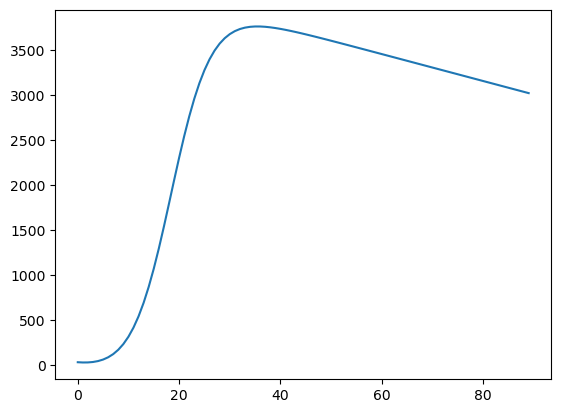

In [15]:
df_severe_byday = simulationFunc (max_sim = 90)
df_severe_byday["金洲社区卫生服务站"].plot()

## Compute weights

In [6]:
df_severe_byday = simulationFunc ()

reach_climax_time_list = []
climax_value_list = []
clinic_name_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]

for name in clinic_name_list:
    reach_climax_time_list.append(reach_climax_time(df_severe_byday, name))
    climax_value_list.append(climax_value(df_severe_byday, name))

clinic_name_climax_time_dic = dict(zip(clinic_name_list, reach_climax_time_list))
clinic_name_climax_value_dic = dict(zip(clinic_name_list, climax_value_list))

df_all = pd.read_excel("community.xlsx")[["社区名称","常住人口","发热诊室", "x", "y"]]
df_all["达峰时间"] = np.zeros(len(df_all))
df_all["峰值"] = np.zeros(len(df_all))

for clinic in clinic_name_list:
    df_all.loc[df_all['发热诊室']==clinic,"达峰时间"] = clinic_name_climax_time_dic[clinic]
    df_all.loc[df_all['发热诊室']==clinic,"峰值"] = clinic_name_climax_value_dic[clinic]

temp = df_all["峰值"]/df_all["达峰时间"]
df_all["w"] = temp / (temp.max())

In [7]:
df_all.head()

,社区名称,常住人口,发热诊室,x,y,达峰时间,峰值,w
0,金山街道金洲社区,8500.0,金洲社区卫生服务站,1154,283,35.0,3767.101065,0.628755
1,金山街道幸福社区,7850.0,丽景社区卫生服务站,801,945,37.0,6333.725979,1.000000
2,金山街道六江道社区,6900.0,中天社区卫生服务站,432,980,36.0,4904.562571,0.795867
3,金山街道金环社区,10832.0,金洲社区卫生服务站,1303,256,35.0,3767.101065,0.628755
4,金山街道鑫龙社区,9000.0,丽景社区卫生服务站,704,479,37.0,6333.725979,1.000000


In [8]:
temp

0     107.631459
1     171.181783
2     136.237849
3     107.631459
4     171.181783
5     107.631459
6     136.237849
7     171.181783
8     165.203093
9     136.237849
10    136.237849
11    136.237849
12    165.203093
13    171.181783
14    165.203093
15    171.181783
16    165.203093
17    107.631459
18    107.631459
19    165.203093
20    171.181783
dtype: float64

## Write the data into excel

In [9]:
output_excel = pd.read_excel("community.xlsx")
output_excel["w"] = df_all["w"]
output_excel.to_excel("community.xlsx")